# <center>Image Captioning <center/>

在最後的實驗中，您學習了如何實現機器翻譯，其中任務是將以源語言編寫的句子S轉換為目標語言中的翻譯T。

機器翻譯中的模型架構是直觀的。一個“編碼器”循環神經網絡（RNN）讀取源句子並將其轉換為一個豐富的固定長度的向量表示，然後將其用作“解碼器”RNN的初始隱藏狀態，該解碼器生成目標句子。

那麼，如果我們查看圖像而不是閱讀句子呢？換句話說，我們使用卷積神經網絡的組合來獲得圖像的向量表示，並使用循環神經網絡將這些表示解碼為自然語言句子。描述不僅必須捕捉圖像中包含的對象，還必須表達這些對象之間的關係，以及它們的屬性和它們參與的活動。

這就是圖像字幕生成，對於機器學習算法來說是一個非常重要的挑戰，因為它相當於模仿人類出色地將大量顯著的視覺信息壓縮成描述性語言的能力。

---

# [m-RNN](https://arxiv.org/abs/1410.1090)

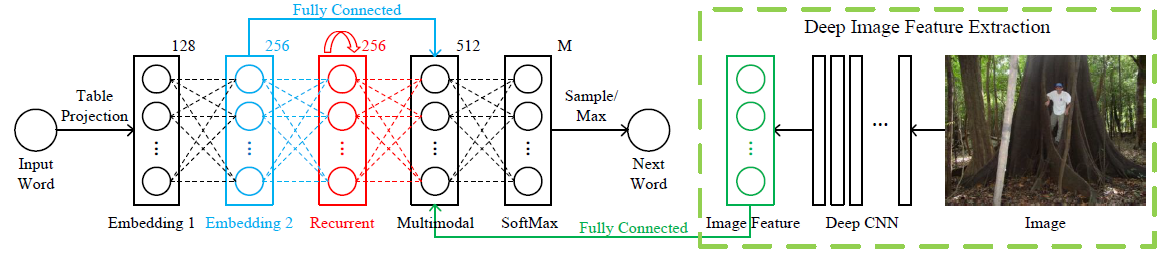


本論文提出了一種多模態循環神經網絡（m-RNN）模型，用於生成關於圖像內容的新型句子描述。
> 據我們所知，這是第一個將循環神經網絡納入深度多模態架構的工作。

整個m-RNN架構包含三個部分：語言模型部分、圖像部分和多模態部分。
- 語言模型部分學習字典中每個詞的密集特徵嵌入，並在遞歸層中存儲語義時間上下文。
- 圖像部分包含一個深度卷積神經網絡（CNN），用於提取圖像特徵。
- 多模態部分通過一個單層表示將語言模型和深度CNN相連接。

必須強調的是：
1. 圖像部分是AlexNet，將AlexNet的第七層連接到多模態層。
2. 該模型在每個時間步骤餵養圖像。

---

# [NIC](https://arxiv.org/abs/1411.4555)

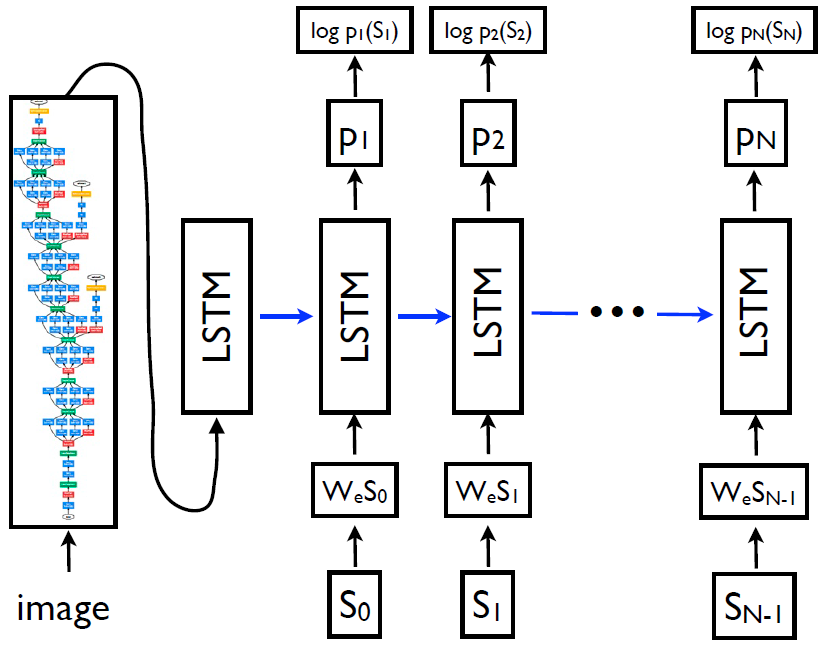

本文提出了一種基於深度循環結構的生成模型，結合了計算機視覺和機器翻譯的最新進展，可用於生成描述圖像的自然句子。該模型使用機器翻譯的編碼器-解碼器框架，將編碼器RNN替換為深度卷積神經網絡。

必須強調的是：
1. 模型在編碼器中使用了一個更強大的CNN，在當時的ILSVRC 2014分類競賽中取得了最佳表現。
2. 為了處理消失和爆炸的梯度問題，在解碼器中引入了LSTM，以基於CNN生成固定長度向量表示的句子。
3. 圖像只在t = -1時輸入，以通知LSTM有關圖像內容。

    > 我們在實踐中驗證了在每個時間步餵入圖像作為額外輸入會產生較差結果，因為網絡可以明確利用圖像中的噪音，更容易過擬合。

---

# [Attention-Based](https://arxiv.org/abs/1502.03044)

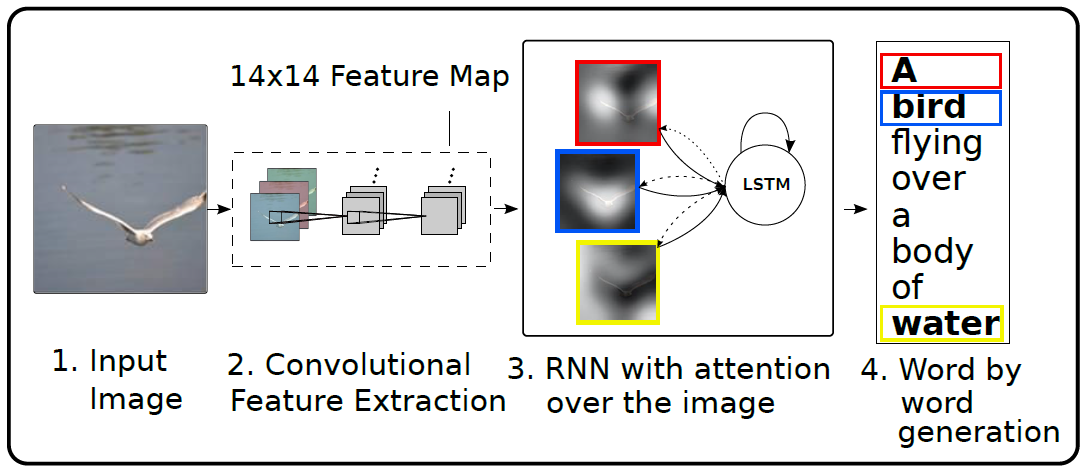

人類視覺系統其中一個最令人好奇的方面是注意力的存在。與將整個圖像壓縮為靜態表示不同，注意力允許顯著特徵根據需要動態地浮現。這在圖像中存在大量混亂時尤為重要。

使用表示（例如來自convnet頂層的表示）將圖像信息提煉為最突出的對象是先前工作中被廣泛採用的一種有效解決方案。不幸的是，這種方法有一個潛在的缺點，可能會損失對於更豐富、更具描述性標題而言可能有用的信息。

使用更低級的表示可以有助於保留這些信息。然而，使用這些特徵需要一個強大的機制來引導模型轉向任務中重要的信息。

本文描述了生成標題的方法，試圖結合一種形式的注意力，其中包括兩種變體：
1. a “soft” deterministic attention mechanism trainable by standard back-propagation methods
2. a “hard” stochastic attention mechanism trainable by maximizing an approximate variational lower bound or equivalently by REINFORCE
上述介紹注意力模型的論文於ICML-2015發表。自那時以來，研究人員開發了許多模型，and the state of the art was broken again and again.

如果您對這一領域感興趣，您還可以點擊此鏈接，該鏈接總結了圖像標題生成的許多優秀論文。

現在，讓我們開始我們的實現。

---

# Image Captioning

給定一張像下面例子一樣的圖片，我們的目標是生成一個標題，如“一名衝浪者在浪上騎行”。

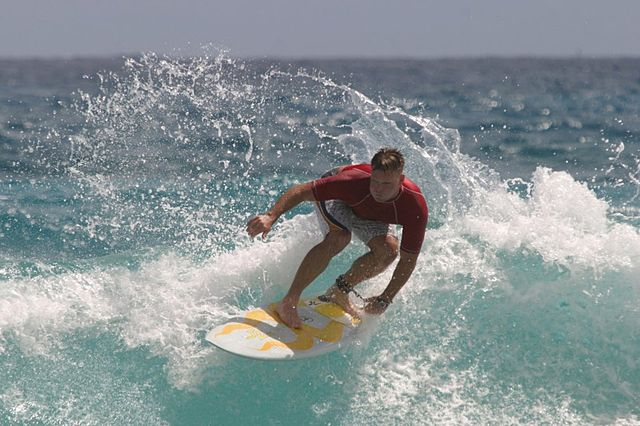

Image Source; License: Public Domain

為了達到這個目標，您將使用一個基於注意力的模型，這使我們能夠看到模型在生成標題時關注圖像的哪些部分。

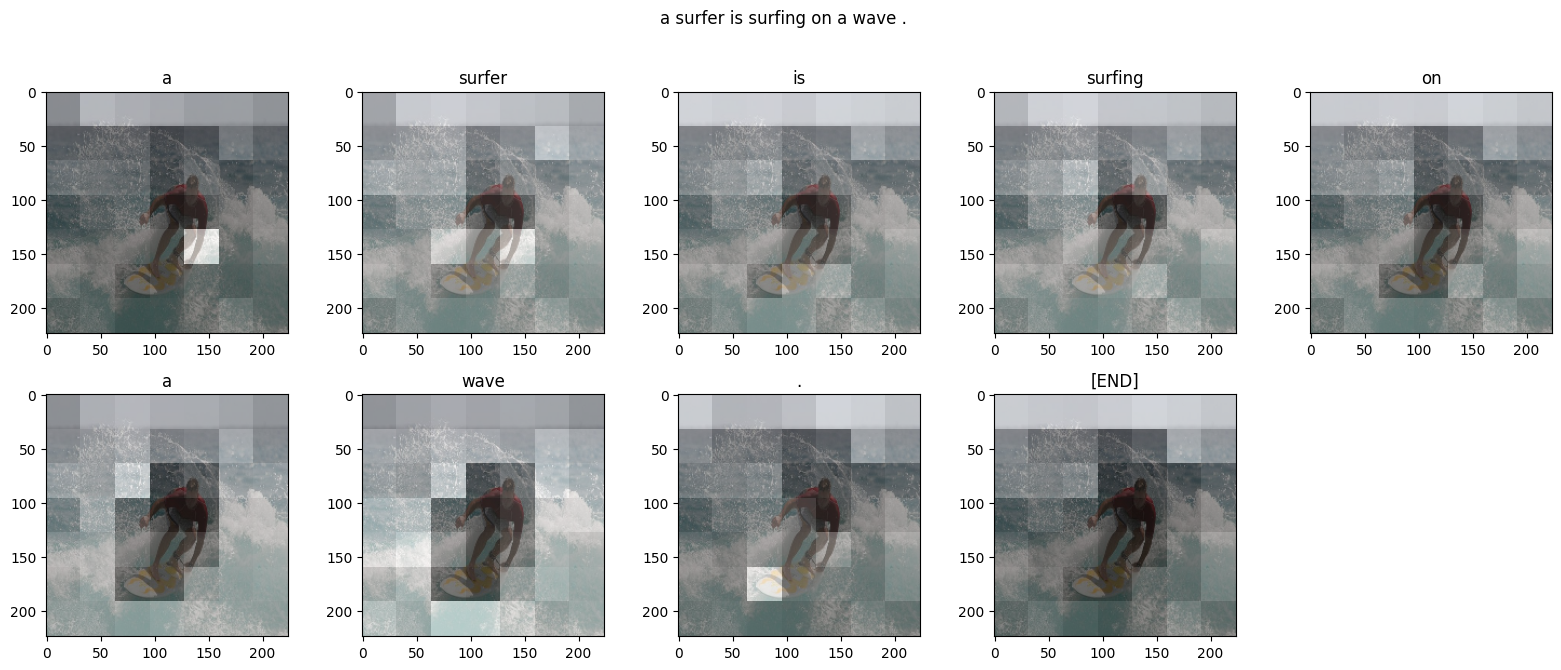

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).


這個筆記本是一個端到端的例子。當您運行這個筆記本時，它會下載 MS-COCO 數據集，使用 Inception V3 預處理和緩存圖像的子集，訓練一個編碼器-解碼器模型，並使用訓練好的模型對新圖像生成標題。

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

# Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over **82,000 images**, each of which has **at least 5 different caption annotations**. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a **13GB** file.

In [5]:
directory = 'C:\\Users\\ying\\Documents\\TCLAB\\Course\\DL\\Deep_learning\\lecture12-2\\tutorial\\dataset\\' # where you want to put the zip files and images
if not os.path.exists(directory+'captions.zip'):
    annotation_zip = tf.keras.utils.get_file( directory + 'captions.zip',
                                              cache_subdir=directory,
                                              origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                              extract = True)
annotation_file = directory +'annotations/captions_train2014.json'


if not os.path.exists(directory + 'train2014.zip'):
    image_zip = tf.keras.utils.get_file(directory + 'train2014.zip',
                                      cache_subdir=directory,
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
PATH = directory +'train2014/'

# Optional: limit the size of the training set

為了加快這個教程的訓練速度，你將使用其中的30,000個標題與相應的圖像子集來訓練我們的模型。選擇使用更多數據將會提高標題生成的質量。

In [6]:
# Read the json file
with open(annotation_file, "r") as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations["annotations"]:
    caption = "<start> " + annot["caption"] + " <end>"
    image_id = annot["image_id"]
    full_coco_image_path = PATH + "COCO_train2014_" + "%012d.jpg" % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions, all_img_name_vector, random_state=1)

# Select the first 30,000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [7]:
len(train_captions), len(all_captions) , len([name for name in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, name))])

(30000, 414113, 82783)

There are tottal 82,783 images with 414,113 captions, but we only use 30,000 captions and their corresponding images to train our model.

# Preprocess the images using InceptionV3

接下來，您將使用在Imagenet上預訓練的InceptionV3來對每張圖片進行分類。您將從最後的卷積層中提取特徵。

首先，您將按照以下步驟將圖片轉換為InceptionV3期望的格式：

- 調整圖片大小為299px x 299px
- 使用preprocess_input方法對圖片進行預處理，以正規化圖片，使其像InceptionV3訓練時使用的圖片格式，像素值在-1到1的範圍內。

In [8]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Initialize InceptionV3 and load the pretrained Imagenet weights

現在，您將創建一個tf.keras模型，其中輸出層是InceptionV3架構中的最後一個卷積層。該層的輸出形狀為8x8x2048。您使用最後一個卷積層是因為在此示例中使用了注意力。在訓練期間，您不執行此初始化，因為這可能會成為一個瓶頸。

- 您將每張圖片通過網絡進行前向傳播，並將結果向量存儲在一個字典中（圖片名稱 --> 特徵向量）。
- 在所有圖片通過網絡後，您將該字典進行序列化（pickle）並保存到磁盤上。

In [14]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet")
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 8s 0us/step


# Caching the features extracted from InceptionV3

您將對每張圖片使用InceptionV3進行預處理，並將輸出緩存到磁盤中。將輸出緩存在RAM中會更快，但也會占用大量內存，每張圖片需要8 * 8 * 2048個浮點數。在筆者撰寫本文時，這超出了Colab的內存限制（目前為12GB內存）。

性能可以通過更複雜的緩存策略進行改善（例如，通過分片(sharding)圖片以減少隨機訪問磁盤I/O），但這將需要更多的代碼。

在Colab上運行緩存大約需要10分鐘，如果您想看到進度條，可以：

1. install tqdm:
    > !pip install -q tqdm

2. Import tqdm:
    > from tqdm import tqdm
3. Change the following line:
    > for img, path in image_dataset:
    to:
    > for img, path in tqdm(image_dataset):


注意：以下的代碼需要超過12GB的內存來保存由InceptionV3提取的特徵。

In [15]:
from tqdm import tqdm

# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3])) # (batch_size, width*height, channel)

    '''
    將處理後的特徵數組 batch_features 與對應的圖片路徑 path 一一配對，然後將每個特徵數組保存為 .npy 文件。.npy 文件是 NumPy 库中用於保存 NumPy 數組的二進制文件格式。
    '''
    # save the preprocessed images to .npy files
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy()) 

100%|██████████| 1622/1622 [08:37<00:00,  3.13it/s]


# Preprocess and tokenize the captions


- 首先，您將對標題進行分詞（例如，通過空格分割）。這將為我們提供數據中所有獨特單詞的詞彙（例如，"surfing"，"football"等）。
- 接下來，您將將詞彙大小限制為前5000個單詞（以節省內存）。您將用標記"UNK"（未知）替換所有其他單詞。
- 然後，您將創建單詞到索引和索引到單詞的映射。
- 最後，您將填充所有序列，使其長度與最長序列相同。

In [16]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [17]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
)
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [18]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [19]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [20]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [21]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

# Split the data into training and testing

In [22]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector, cap_vector, test_size=0.2, random_state=0)

In [23]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

# Create a tf.data dataset for training

Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [24]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 100
BUFFER_SIZE = 5000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [25]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [26]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Model

有趣的事實：下面的解碼器與注意機制的神經機器翻譯範例中的解碼器完全相同。

該模型的架構靈感來自《Show, Attend and Tell》論文。
- 在這個例子中，您從InceptionV3模型的較低卷積層中提取特徵，得到一個形狀為（8, 8, 2048）的向量。
- 然後將其壓縮成形狀為（64, 2048）的向量。
- 接著，該向量通過CNN編碼器（由一個全連接層組成）。
- 最後，RNN（這裡是GRU）對圖像進行注意力機制，以預測下一個單詞。

In [27]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [28]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [29]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer="glorot_uniform")
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [30]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [33]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

# Checkpoint

In [34]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

In [35]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])

# Training


- 你從相應的 .npy 文件中提取特徵，然後通過編碼器處理這些特徵。
- 編碼器的輸出、隱藏狀態（初始化為0）和解碼器的輸入（即開始標記）被傳遞給解碼器。
- 解碼器返回預測和解碼器的隱藏狀態。
- 然後，解碼器的隱藏狀態被傳遞回模型，並使用預測來計算損失。
- 使用教師強制（teacher forcing）來決定解碼器的下一個輸入。
- 教師強制是一種技術，其中將目標單詞作為解碼器的下一個輸入。
- 最後一步是計算梯度，將其應用於優化器並執行反向傳播。

In [36]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [37]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [38]:
EPOCHS = 50
start = time.time()
for epoch in range(start_epoch, EPOCHS):
    
    total_loss = 0

    for (batch, (img_tensor, target)) in tqdm(enumerate(dataset), total=num_steps):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

#         if batch % 100 == 0:
#             print ('Epoch {} Batch {} Loss {:.4f}'.format(
#               epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
print ('Time taken for {} epoch {} sec\n'.format(EPOCHS, time.time() - start))

100%|██████████| 240/240 [02:48<00:00,  1.43it/s]


Epoch 1 Loss 1.144315


100%|██████████| 240/240 [01:13<00:00,  3.27it/s]


Epoch 2 Loss 0.873579


100%|██████████| 240/240 [01:10<00:00,  3.38it/s]


Epoch 3 Loss 0.779756


100%|██████████| 240/240 [01:12<00:00,  3.32it/s]


Epoch 4 Loss 0.725527


100%|██████████| 240/240 [01:10<00:00,  3.40it/s]


Epoch 5 Loss 0.685354


100%|██████████| 240/240 [01:11<00:00,  3.36it/s]


Epoch 6 Loss 0.651806


100%|██████████| 240/240 [01:11<00:00,  3.37it/s]


Epoch 7 Loss 0.621683


100%|██████████| 240/240 [01:10<00:00,  3.41it/s]


Epoch 8 Loss 0.592747


100%|██████████| 240/240 [01:12<00:00,  3.33it/s]


Epoch 9 Loss 0.563979


100%|██████████| 240/240 [01:12<00:00,  3.31it/s]


Epoch 10 Loss 0.535015


100%|██████████| 240/240 [01:10<00:00,  3.38it/s]


Epoch 11 Loss 0.515067


100%|██████████| 240/240 [01:14<00:00,  3.22it/s]


Epoch 12 Loss 0.505848


100%|██████████| 240/240 [01:17<00:00,  3.11it/s]


Epoch 13 Loss 0.463368


100%|██████████| 240/240 [01:59<00:00,  2.01it/s]


Epoch 14 Loss 0.433529


100%|██████████| 240/240 [01:20<00:00,  3.00it/s]


Epoch 15 Loss 0.406980


100%|██████████| 240/240 [01:23<00:00,  2.86it/s]


Epoch 16 Loss 0.382362


100%|██████████| 240/240 [01:13<00:00,  3.29it/s]


Epoch 17 Loss 0.356827


100%|██████████| 240/240 [01:11<00:00,  3.33it/s]


Epoch 18 Loss 0.333857


100%|██████████| 240/240 [01:11<00:00,  3.35it/s]


Epoch 19 Loss 0.310651


100%|██████████| 240/240 [01:10<00:00,  3.38it/s]


Epoch 20 Loss 0.293670


100%|██████████| 240/240 [01:12<00:00,  3.31it/s]


Epoch 21 Loss 0.284021


100%|██████████| 240/240 [01:11<00:00,  3.34it/s]


Epoch 22 Loss 0.255146


100%|██████████| 240/240 [01:11<00:00,  3.37it/s]


Epoch 23 Loss 0.235167


100%|██████████| 240/240 [01:10<00:00,  3.41it/s]


Epoch 24 Loss 0.219960


100%|██████████| 240/240 [01:08<00:00,  3.52it/s]


Epoch 25 Loss 0.208217


100%|██████████| 240/240 [01:06<00:00,  3.58it/s]


Epoch 26 Loss 0.192155


100%|██████████| 240/240 [01:05<00:00,  3.67it/s]


Epoch 27 Loss 0.180683


100%|██████████| 240/240 [01:04<00:00,  3.70it/s]


Epoch 28 Loss 0.173199


100%|██████████| 240/240 [01:04<00:00,  3.69it/s]


Epoch 29 Loss 0.161862


100%|██████████| 240/240 [01:05<00:00,  3.69it/s]


Epoch 30 Loss 0.147188


100%|██████████| 240/240 [01:09<00:00,  3.43it/s]


Epoch 31 Loss 0.139181


100%|██████████| 240/240 [01:12<00:00,  3.32it/s]


Epoch 32 Loss 0.134600


100%|██████████| 240/240 [01:05<00:00,  3.68it/s]


Epoch 33 Loss 0.122840


100%|██████████| 240/240 [01:05<00:00,  3.67it/s]


Epoch 34 Loss 0.119257


100%|██████████| 240/240 [01:05<00:00,  3.67it/s]


Epoch 35 Loss 0.110683


100%|██████████| 240/240 [01:31<00:00,  2.62it/s]


Epoch 36 Loss 0.108895


100%|██████████| 240/240 [01:03<00:00,  3.80it/s]


Epoch 37 Loss 0.101981


100%|██████████| 240/240 [01:03<00:00,  3.81it/s]


Epoch 38 Loss 0.097443


100%|██████████| 240/240 [01:02<00:00,  3.81it/s]


Epoch 39 Loss 0.090723


100%|██████████| 240/240 [01:03<00:00,  3.81it/s]


Epoch 40 Loss 0.090740


100%|██████████| 240/240 [01:03<00:00,  3.80it/s]


Epoch 41 Loss 0.087274


100%|██████████| 240/240 [01:03<00:00,  3.80it/s]


Epoch 42 Loss 0.084813


100%|██████████| 240/240 [01:03<00:00,  3.80it/s]


Epoch 43 Loss 0.080754


100%|██████████| 240/240 [01:03<00:00,  3.81it/s]


Epoch 44 Loss 0.076496


100%|██████████| 240/240 [01:03<00:00,  3.79it/s]


Epoch 45 Loss 0.079999


100%|██████████| 240/240 [01:24<00:00,  2.85it/s]


Epoch 46 Loss 0.075915


100%|██████████| 240/240 [01:34<00:00,  2.55it/s]


Epoch 47 Loss 0.071564


100%|██████████| 240/240 [01:33<00:00,  2.55it/s]


Epoch 48 Loss 0.073391


100%|██████████| 240/240 [01:34<00:00,  2.55it/s]


Epoch 49 Loss 0.070141


100%|██████████| 240/240 [01:34<00:00,  2.54it/s]

Epoch 50 Loss 0.065490
Time taken for 50 epoch 3756.268338918686 sec



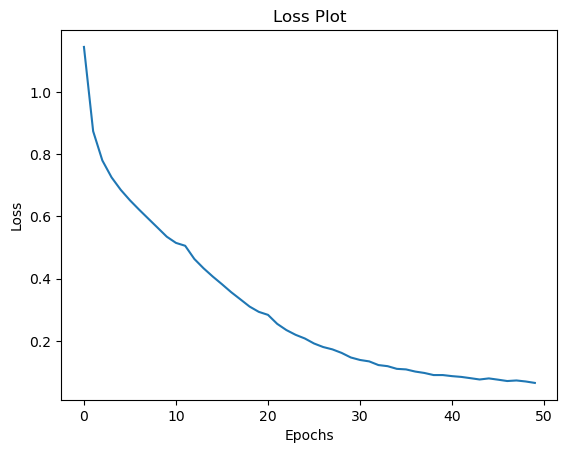

In [39]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Caption!

- `evaluate` 函數與訓練循環類似，但在這裡不使用教師強制。解碼器在每個時間步的輸入是其先前的預測、隱藏狀態和編碼器的輸出。
- 當模型預測到結束標記時，停止預測。同時，儲存每個時間步的注意權重。
- 簡而言之，這個函數的目的是使用解碼器生成序列，並在達到結束標記時停止生成。同時，它還儲存了每個時間步的注意權重。

In [40]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [41]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a line of people shield themselves from the rain with umbrellas <end>
Prediction Caption: black three men one woman crossing a wet sidewalk <end>


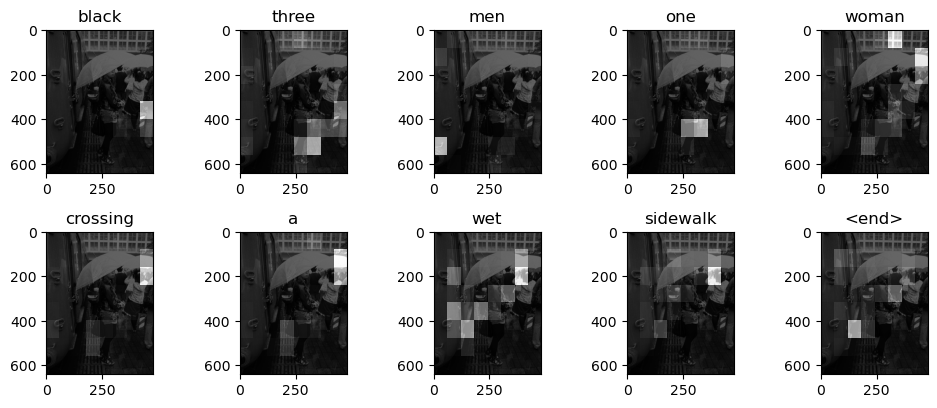

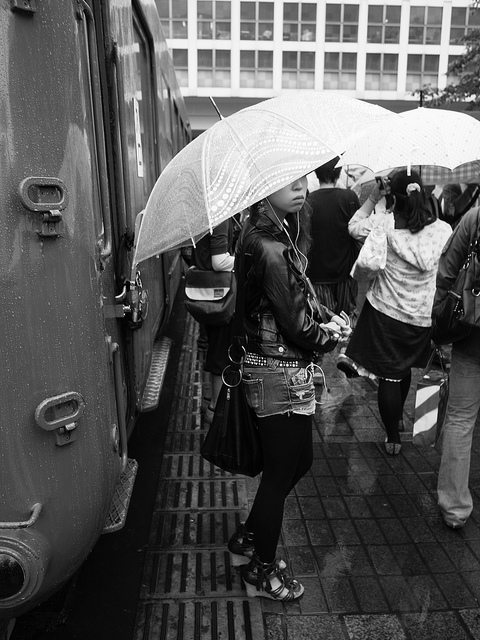

In [42]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])

# Try it on your own images

64400/64400 [==============================] - 0s 4us/step
Prediction Caption: a man on a wave in some surf board <end>


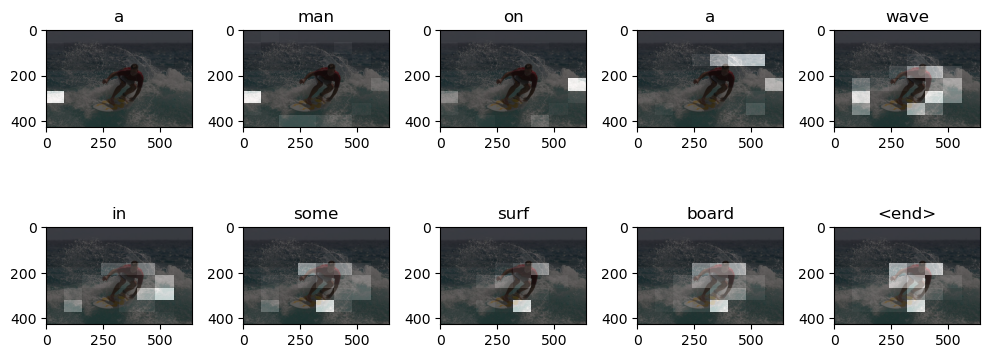

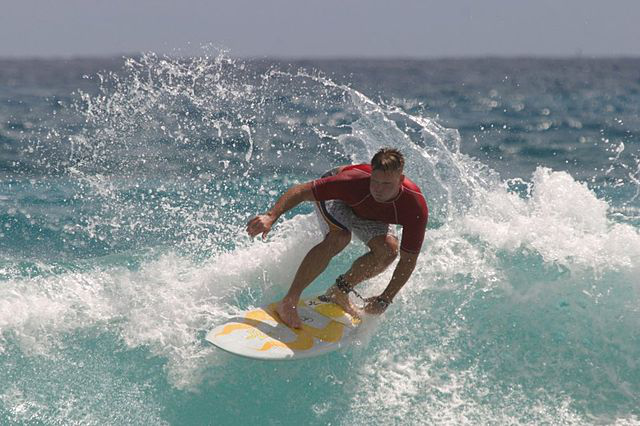

In [43]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)